# Frequentist Inference Case Study - Part B

## Learning objectives

Welcome to Part B of the Frequentist inference case study! The purpose of this case study is to help you apply the concepts associated with Frequentist inference in Python. In particular, you'll practice writing Python code to apply the following statistical concepts: 
* the _z_-statistic
* the _t_-statistic
* the difference and relationship between the two
* the Central Limit Theorem, including its assumptions and consequences
* how to estimate the population mean and standard deviation from a sample
* the concept of a sampling distribution of a test statistic, particularly for the mean
* how to combine these concepts to calculate a confidence interval

In the previous notebook, we used only data from a known normal distribution. **You'll now tackle real data, rather than simulated data, and answer some relevant real-world business problems using the data.**

## Hospital medical charges

Imagine that a hospital has hired you as their data scientist. An administrator is working on the hospital's business operations plan and needs you to help them answer some business questions. 

In this assignment notebook, you're going to use frequentist statistical inference on a data sample to answer the questions:
* has the hospital's revenue stream fallen below a key threshold?
* are patients with insurance really charged different amounts than those without?

Answering that last question with a frequentist approach makes some assumptions, and requires some knowledge, about the two groups.

We are going to use some data on medical charges obtained from [Kaggle](https://www.kaggle.com/easonlai/sample-insurance-claim-prediction-dataset). 

For the purposes of this exercise, assume the observations are the result of random sampling from our single hospital. Recall that in the previous assignment, we introduced the Central Limit Theorem (CLT), and its consequence that the distributions of sample statistics approach a normal distribution as $n$ increases. The amazing thing about this is that it applies to the sampling distributions of statistics that have been calculated from even highly non-normal distributions of data! Recall, also, that hypothesis testing is very much based on making inferences about such sample statistics. You're going to rely heavily on the CLT to apply frequentist (parametric) tests to answer the questions in this notebook.

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import t
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [2]:
medical = pd.read_csv('data/raw/insurance2.csv')

In [3]:
plt_elements = ['#9C9FA6', '#95A68D', '#735953']
plt_highlights = ['#0D0D0D', '#F2D857', '#9AAAC4']
colors = {'el': plt_elements, 'hl': plt_highlights}

In [4]:
def print_floats(label_val_dict: dict[str:float], title:str = '') -> None:
    print(f'{title}:\n{79*"_"}')
    label_col_width = 5 + max([len(label) for label in label_val_dict.keys()])
    val_digits = 3 + max([
        len(f'{v}'[:f'{v}'.index('.')]) for v in label_val_dict.values()
    ])
    for label, value in label_val_dict.items():
        label = f'{label}:'.ljust(label_col_width)
        value = f'{value:.3f}'.split('.')
        value = '.'.join([value[0].rjust(val_digits), value[1]])
        print('|'.join([label, value]))
    print(f'\n{79*"-"}\n')

In [5]:
medical.shape

(1338, 8)

In [6]:
medical.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


__Q1:__ Plot the histogram of charges and calculate the mean and standard deviation. Comment on the appropriateness of these statistics for the data.

__A:__

The provided data is likely sufficient to determine whether average charges have fallen below a business-relevant critical threshold. As indicated in the histogram below, this sample is not normally distributed. Therefore, the sample mean and sample standard deviation do not usefully describe this sample's distribution. The administrator is only interested in the relationship between a critical value and the population mean. Without information on the nature of the population from which this sample was drawn, I cannot comment on whether this sample is truly random, independent, or representative of the population. Assuming the sample is random, the sample size is less than 10% of the population size, and the sample variance is representative of the population variance, the sample mean should offer a useful approximation of the population mean within a range calculated later in this notebook. A t-test will facilitate the comparison of an estimated population mean with the critical threshold.
<br><br>
The provided data is decidedly insufficient to answer whether individuals without insurance are charged differently than individuals with insurance. Among other serious concerns, there is no information on what procedures are performed on, or what goods or services were provided to, the patients in this dataset. It is not possible to make like comparisons. This alone is enough to invalidate most conclusions one might attempt to draw from this dataset. When a patient's treatment may follow more than one particular course, the selection of treatment methods likely depends, at least in part, on a patient's insurance plan or lack thereof. Further, I imagine insured patient charges will have significantly higher variance. Insured patients are more likely to have routine checkups, and insured patients are more likely to agree to prohibitively expensive (to those without insurance) treatment options or procedures.
<br><br>
Excepting other issues, Welch's t-test may offer more accurate insight than the standard 2 sample t-test used below. In any case, without additional data, it is difficult to imagine arriving at any genuinely useful assessment of the relationship between hospital charges and a patient's insurance status. Any conclusions drawn to that end are strictly academic.

In [7]:
charges_mean = np.mean(medical.charges)
charges_std = np.std(medical.charges, ddof=1)

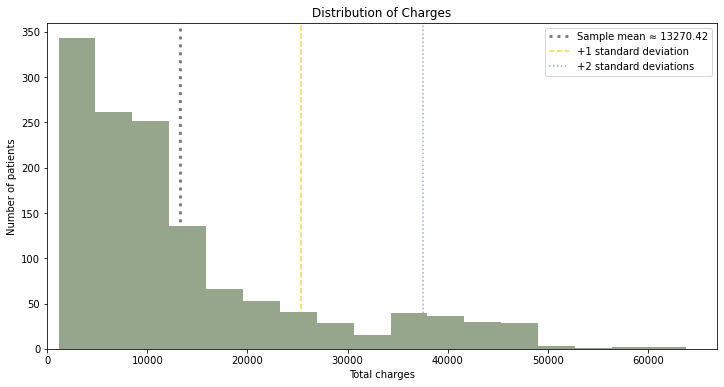

medical charges statistics:
_______________________________________________________________________________
mean:                  |   13270.422
standard deviation:    |   12110.011

-------------------------------------------------------------------------------



In [8]:
fig, ax = plt.subplots(figsize=(12,6))
_ = ax.axvline(
    charges_mean, lw=3, color='black', zorder=1, 
    label=f'Sample mean ≈ {charges_mean:.2f}', alpha=0.5,
    linestyle=':'
)
for multiple, style in [(1, '--'), (2, ':')]:
    dx = multiple * charges_std
    for y in (charges_mean + dx,):
        _ = ax.axvline(
            y, linestyle = style, color=colors['hl'][multiple],
            label=f'+{multiple} standard deviation{(multiple - 1) * "s"}',
            zorder=0
        )
_ = ax.hist(medical.charges, color=colors['el'][1], bins=17, zorder=1)
_ = ax.set_xlim(0)
_ = plt.legend()
_ = plt.title('Distribution of Charges')
_ = plt.xlabel('Total charges')
_ = plt.ylabel('Number of patients')
plt.show()
print_floats(
    {'mean':charges_mean, 'standard deviation':charges_std},
    'medical charges statistics'
)

In [9]:
is_insured = medical.insuranceclaim==1
insured_charges = medical[is_insured].charges
uninsured_charges = medical[~is_insured].charges
insured_mean, uninsured_mean = map(
    np.mean, [insured_charges, uninsured_charges]
)
insured_std, uninsured_std = map(
    lambda data: np.std(data, ddof=1),
    [insured_charges, uninsured_charges]
)

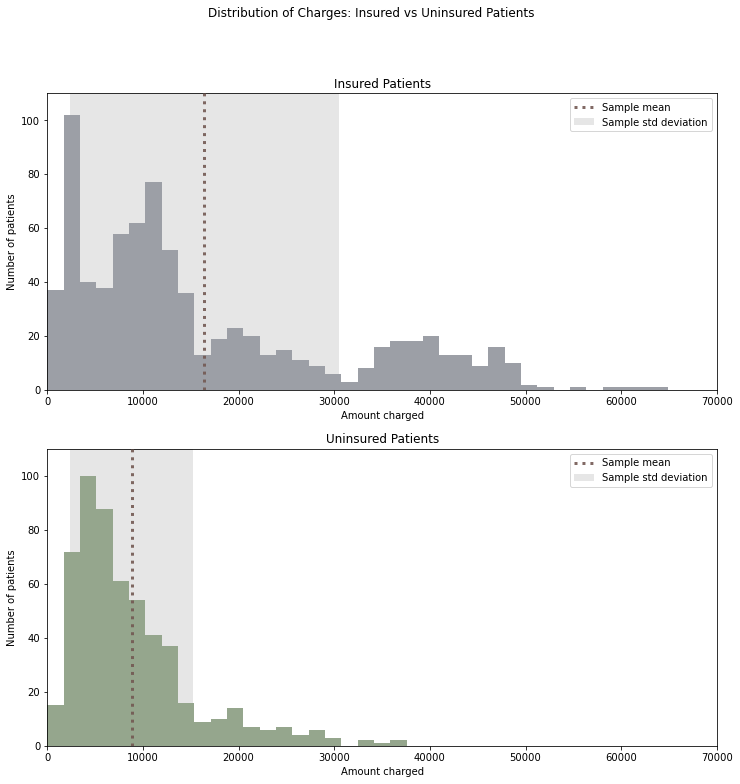

Insured Patients:
_______________________________________________________________________________
sample mean:             |   16423.928
sample std deviation:    |   14045.928

-------------------------------------------------------------------------------

Uninsured Patients:
_______________________________________________________________________________
sample mean:             |   8821.422
sample std deviation:    |   6446.510

-------------------------------------------------------------------------------



In [10]:
fig, ax = plt.subplots(2, figsize=(12, 12))
bins = [i/41 * 70000 for i in range(42)]
_ = fig.suptitle('Distribution of Charges: Insured vs Uninsured Patients')
for subplot_ax, title, data, color in [
        (ax[0], 'Insured Patients', insured_charges, colors['el'][0]),
        (ax[1], 'Uninsured Patients', uninsured_charges, colors['el'][1])
]:
    _ = subplot_ax.hist(data, color=color, bins=bins, zorder=2)
    _ = subplot_ax.set_title(title)
    _ = subplot_ax.set_xlabel('Amount charged')
    _ = subplot_ax.set_ylabel('Number of patients')
    _ = subplot_ax.axvline(
        data.mean(), color=colors['el'][2], lw=3, linestyle=':', 
        label='Sample mean', zorder=3, alpha=0.9
    )
    std = np.std(data, ddof=1)
    _ = subplot_ax.add_patch(
        Rectangle(
            [data.mean() -std, 0], 2 * std, 150, facecolor='#E6E6E6', 
            label='Sample std deviation', zorder=0
        )
    )
    _ = subplot_ax.set_xlim(0, 70000)
    _ = subplot_ax.set_ylim(0, 110)
    _ = subplot_ax.legend()
plt.show()
for title, data in [
        ('Insured Patients', insured_charges), 
        ('Uninsured Patients', uninsured_charges)
    ]:
    aggs = {
        'sample mean': data.mean(), 'sample std deviation': np.std(data, ddof=1)
    }
    print_floats(aggs, title)

__Q2:__ The administrator is concerned that the actual average charge has fallen below 12,000, threatening the hospital's operational model. On the assumption that these data represent a random sample of charges, how would you justify that these data allow you to answer that question? And what would be the most appropriate frequentist test, of the ones discussed so far, to apply?

__A:__

Assuming this is a random, representative, and independent sample, I would argue that the central limit theorem provides an adequate foundation for the use of this data to address the administrator's concern. Of the frequentist tests discussed so far, a one-sample, single-tail t test is most appropriate.

__Q3:__ Given the nature of the administrator's concern, what is the appropriate confidence interval in this case? A ***one-sided*** or ***two-sided*** interval? (Refresh your understanding of this concept on p. 399 of the *AoS*). Calculate the critical value and the relevant 95% confidence interval for the mean, and comment on whether the administrator should be concerned.

__A:__

Given the nature of the administrator's concern, the appropriate confidence interval is one-sided. The administrator aims to determine the relationship between the population mean charge and the <span>$</span>12,000 critical threshold presented in Q2. They are specifically concerned that the average patient's total charge has fallen below the critical threshold.

In [11]:
mean_charge_threshold = 12000
sample_n = len(medical)
df = sample_n - 1
confidence_interval = 0.95
tail_prob = 1 - 0.95
critical_t = t.ppf(tail_prob, df)
print(f'critical t value: {critical_t}')

critical t value: -1.6459941145571317


In [12]:
charges_mean_moe = critical_t * charges_std / np.sqrt(len(medical))
print(f'mean margin of error ≈ {charges_mean_moe:,.2f}')

mean margin of error ≈ -544.94


In [13]:
ci = [charges_mean + charges_mean_moe, charges_mean]
print(
    f'95% confidence interval - single tail \n'
    + f'lower bound ≈ $ {ci[0]:,.2f}\n'
)

95% confidence interval - single tail 
lower bound ≈ $ 12,725.49



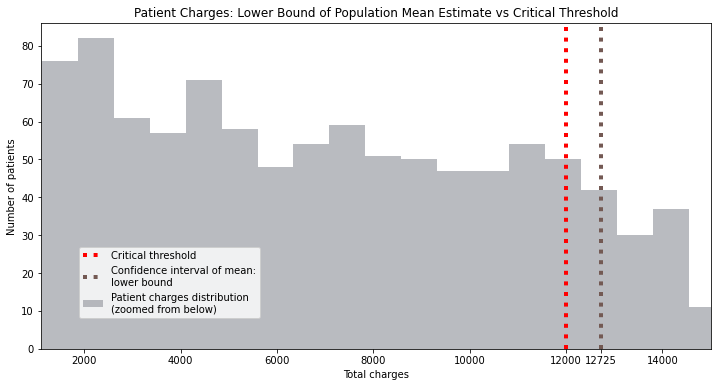

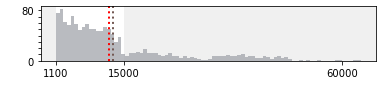

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))
_ = ax.axvline(
    12000, color='r', ls=':', lw=4, label='Critical threshold',
    zorder=1
)
_ = ax.axvline(
    ci[0], color=colors['el'][2], ls=':', lw=4, 
    label='Confidence interval of mean:\nlower bound', zorder=1
)
ax.hist(
    medical.charges, bins=84, zorder=0, color=colors['el'][0], 
    label='Patient charges distribution \n(zoomed from below)', alpha=0.7
)
_ = ax.set_ylim(0)
_ = ax.set_xlim(1100, 15000)
_ = ax.legend(loc='lower left', bbox_to_anchor=(0.05, 0.08))
_ = ax.set_xlabel('Total charges')
_ = ax.set_ylabel('Number of patients')
_ = ax.set_xticks((2000, 4000, 6000, 8000, 10000, 12000, ci[0], 14000))
_ = ax.set_title(
    'Patient Charges: Lower Bound of Population Mean '
    + 'Estimate vs Critical Threshold'
)
plt.show();
fig, ax = plt.subplots(figsize=(6, 1))
_ = ax.set_facecolor('#f0f0f0')
_ = ax.hist(medical.charges, bins=84, color=colors['el'][0], alpha=0.7)
_ = ax.axvline(12000, color='r', ls=':', lw=2, zorder=1)
_ = ax.axvline(ci[0], color=colors['el'][2], ls=':', lw=2, zorder=1)
_ = ax.set_xticks((1100, 15000, 60000))
_ = ax.set_yticks(range(0, 81, 10))
_ = ax.set_yticklabels(['0'] + ['' for _ in range(7)] + ['80'])
_ = ax.add_patch(Rectangle(
    [1100, 0], 15000-1100, 90, facecolor='white', zorder=0
))
_ = ax.set_ylabel(' ')
plt.show();

The administrator then wants to know whether people with insurance really are charged a different amount to those without.

__Q4:__ State the null and alternative hypothesis here. Use the _t_-test for the difference between means, where the pooled standard deviation of the two groups is given by:
\begin{equation}
s_p = \sqrt{\frac{(n_0 - 1)s^2_0 + (n_1 - 1)s^2_1}{n_0 + n_1 - 2}}
\end{equation}

and the *t*-test statistic is then given by:

\begin{equation}
t = \frac{\bar{x}_0 - \bar{x}_1}{s_p \sqrt{1/n_0 + 1/n_1}}.
\end{equation}

(If you need some reminding of the general definition of ***t-statistic***, check out the definition on p. 404 of *AoS*). 

What assumption about the variances of the two groups are we making here?

__A:__

The null hypothesis is that the average charge of individuals without insurance is not significantly different than that of indivudals with insurance.
The alternative hypothesis is that individuals without insurance are, on average, charged more or charged less than indivudals with insurance. <br><br>
The sample variance of the two groups in question is assumed to be representative of the population variances of these groups. Given the calculations presented in Q4, this exercise also assumes that the two groups have equal variance. The relevant test is a two-sample t test.

__Q5:__ Perform this hypothesis test both manually, using the above formulae, and then using the appropriate function from [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html#statistical-tests) (hint, you're looking for a function to perform a _t_-test on two independent samples). For the manual approach, calculate the value of the test statistic and then its probability (the p-value). Verify you get the same results from both.

__A:__ 

Perform hypothesis test manually.

In [15]:
s_std = lambda sample: np.std(sample, ddof=1)

i_u = (insured_charges, uninsured_charges)
n_i, n_u = map(len, i_u)
s_i, s_u = map(s_std, i_u)
x_i, x_u = map(np.mean, i_u)

pooled_std = np.sqrt(
    ((n_i - 1)*s_i**2 + (n_u - 1)*s_u**2)
    /
    (n_i + n_u - 2)
)
print(f'pooled standard deviation: {pooled_std}')

pooled standard deviation: 11520.034268775256


In [16]:
t_test_statistic = (
    (x_i - x_u)
    /
    (pooled_std * np.sqrt(1/n_i + 1/n_u))
)
p_val = 2 * t.sf(t_test_statistic, df=n_i + n_u - 2)
print(f't-test statistic: {t_test_statistic}\np-value: {p_val}')

t-test statistic: 11.89329903087671
p-value: 4.461230231620972e-31


Perform hypothesis test using `scipy.stats.t_test_ind`. Verify results are identical (to 20 decimal places).

In [17]:
scipy_ttest = ttest_ind(insured_charges, uninsured_charges)
scipy_t_test_stat = scipy_ttest[0]
scipy_p_val = scipy_ttest[1]
assert round(scipy_t_test_stat, 20) == round(t_test_statistic, 20)
assert round(scipy_p_val, 20) == round(p_val, 20)
print(
    f'scipy results:\n'
    + f't-test statistic: {scipy_t_test_stat}\n'
    + f'p-value: {scipy_p_val}'
)


scipy results:
t-test statistic: 11.893299030876712
p-value: 4.461230231620717e-31


Congratulations! Hopefully you got the exact same numerical results. This shows that you correctly calculated the numbers by hand. Secondly, you used the correct function and saw that it's much easier to use. All you need to do is pass your data to it.

__Q6:__ Conceptual question: look through the documentation for statistical test functions in scipy.stats. You'll see the above _t_-test for a sample, but can you see an equivalent one for performing a *z*-test from a sample? Comment on your answer.

__A:__

There is no equivalent function. Z-tests are used when population parameters are known.

## Learning outcomes

Having completed this project notebook, you now have good hands-on experience:
* using the central limit theorem to help you apply frequentist techniques to answer questions that pertain to very non-normally distributed data from the real world
* performing inference using such data to answer business questions
* forming a hypothesis and framing the null and alternative hypotheses
* testing this using a _t_-test